# Industries Project

Author: Mateo Marks

The goal of this work is to test how various industries perform in different economic regimes in the US. Economic regimes will be defined using combination of  GDP growth and CPI change.

## Import required packages

To begin, we will download the required packages that we will use during the analysis as well as formating some common attributes for the plots that will be created through the work.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import math

### Graph Formatting

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14; MEDIUM_SIZE = 16; BIGGER_SIZE = 18

plt.rc('font', size = SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize = SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize = MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize = SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize = SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize = BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize = (10,6))         # size fo the graph

## Import Economic Indicators

The first inputs we will retrieve are the US economic indicators that we will use to generate the four regimes. To simplify the analysis, we will work with yearly data.

In [3]:
economic_data = pd.DataFrame()

The US inflation is the annual change in consumer prices for the United States.

Source: https://fred.stlouisfed.org/series/FPCPITOTLZGUSA

In [4]:
excel_file = "US_Inflation.xlsx"

CPI_raw = pd.read_excel(excel_file, header=0,index_col=0, sheet_name='Data', engine='openpyxl')/100
CPI_raw.index = pd.to_datetime(CPI_raw.index, format="%Y-%m-%d").to_period('Y')
economic_data['inflation'] = CPI_raw

The GDP growth is the annual change in Real Gross Domestic Product (Billions of Chained 2012 Dollars).

Source: https://fred.stlouisfed.org/series/GDPC1#0

In [5]:
excel_file = "US_GDP.xlsx"

GDP_raw = pd.read_excel(excel_file, header=0,index_col=0, sheet_name='Data', engine='openpyxl')
GDP_raw.index = pd.to_datetime(GDP_raw.index, format="%Y-%m-%d").to_period('Y')
GDP_raw = np.log(GDP_raw/GDP_raw.shift(1)).dropna()
economic_data['growth'] = GDP_raw

In [6]:
economic_data.head()

,inflation,growth
Year,,
1960,0.014580,0.008788
1961,0.010707,0.061993
1962,0.011988,0.042169
1963,0.012397,0.050296
1964,0.012789,0.050278


Having a quick look at the data, we can see that we have 62 obvervations, and it seems that there are no outliers. 

In [7]:
economic_data.describe()

,inflation,growth
count,62.000000,62.000000
mean,0.036965,0.029372
std,0.027536,0.022389
min,-0.003555,-0.025732
25%,0.018337,0.018859
50%,0.029834,0.027286
75%,0.042986,0.043678
max,0.135492,0.081231


As an extra analysis, we plotted the histogram of both indicators and compared them against a normal distribution bell. 

In [8]:
def dN(x,mu,sigma):
    '''Probability density function of a normal
    random variable
    '''
    z = (x - mu) / sigma
    pdf=np.exp(-0.5 * z ** 2) / math.sqrt(2 * math.pi * sigma ** 2)
    return pdf

In [9]:
def return_histogram(name,rets):
    '''Plot a Histogram
    '''
    plt.figure(figsize=(10,6))
    x = np.linspace(min(rets), max(rets), 100)
    plt.hist(np.array(rets), bins=50, density=True)
    y = dN(x, np.mean(rets), np.std(rets))
    plt.plot(x, y, linewidth = 2)
    plt.xlabel('change')
    plt.ylabel('frequency/probability')
    plt.grid(True)
    title = name + " histogram of change"
    plt.title(title)

We can see in the plots below that neither of the economic indicators is normally distributed.

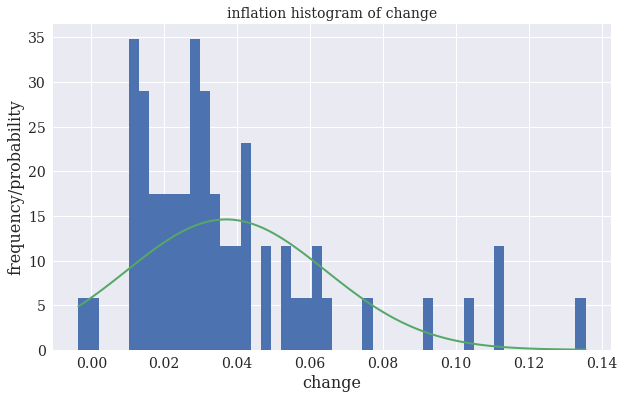

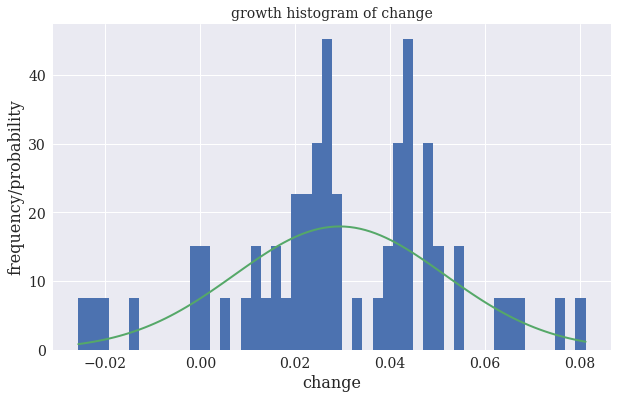

In [10]:
for sym in economic_data.columns:
    return_histogram(sym, economic_data[sym].values)

Even though there are multiple and more complex ways that we can generate the 4 regimes, we will divide the economy in four scenatios:
- Reflation: Inflation and growth below the median.
- Recovery: Inflation below the median and growth above the median.
- Stagflation: Inflation above the median and growth below the median.
- Overheat: Inflation and growth above the median.

In [11]:
# The median inflation is 2.98%

med_inflation = np.median(economic_data['inflation'], axis=0)
med_inflation

0.029833661716349647

In [12]:
# The median GDP growth is 2.73%

med_growth = np.median(economic_data['growth'], axis=0)
med_growth

0.027285580121212134

In [13]:
def categorize(year):
    if (year['inflation'] < med_inflation) and (year['growth'] < med_growth):
        val = 'Reflation'
    elif (year['inflation'] < med_inflation) and (year['growth'] >= med_growth):
        val = 'Recovery'
    elif (year['inflation'] >= med_inflation) and (year['growth'] < med_growth):
        val = 'Stagflation'
    elif (year['inflation'] >= med_inflation) and (year['growth'] >= med_growth):
        val = 'Overheat'
    return val

In [14]:
economic_data['regimes'] = economic_data.apply(categorize, axis=1)

In [15]:
economic_data['regimes'].value_counts()

Reflation      17
Overheat       17
Recovery       14
Stagflation    14
Name: regimes, dtype: int64

The chart is a representation of the relationship between inflation and GDP growth. The colours represent the regimes that we just created.

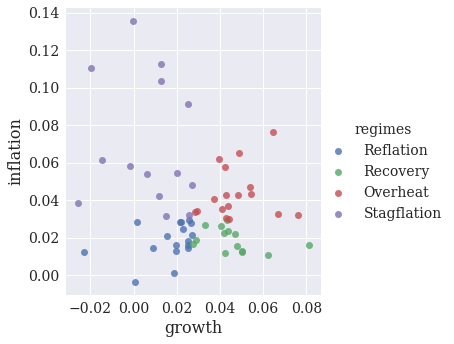

In [16]:
sns.lmplot(
    data=economic_data,
    y="inflation", x="growth", fit_reg=False, hue='regimes');

In [17]:
regimes = economic_data['regimes']

## Import Industry Metrics

The next step will be retrieving and analyzing the US industries' annual returns.

***
>Categories construction: Assigns each NYSE, AMEX, and NASDAQ stock to an industry portfolio at the end of June of year t based on its four-digit SIC code at that time. (Uses Compustat SIC codes for the fiscal year ending in calendar year t-1. Whenever Compustat SIC codes are not available, uses CRSP SIC codes for June of year t.) Then computes returns from July of t to June of t+1
***
 
 1. NoDur  Consumer Nondurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys
 2. Durbl  Consumer Durables -- Cars, TVs, Furniture, Household Appliances
 3. Manuf  Manufacturing -- Machinery, Trucks, Planes, Chemicals, Off Furn, Paper, Com Printing
 4. Enrgy  Oil, Gas, and Coal Extraction and Products
 5. HiTec  Business Equipment -- Computers, Software, and Electronic Equipment
 6. Telcm  Telephone and Television Transmission
 7. Shops  Wholesale, Retail, and Some Services (Laundries, Repair Shops)
 8. Hlth   Healthcare, Medical Equipment, and Drugs
 9. Utils  Utilities
 10. Other -- Other Mines, Constr, BldMt, Trans, Hotels, Bus Serv, Entertainment, Finance

Source: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_10_ind_port.html

In [18]:
excel_file = "Industry_Portfolios.xlsx"

ind_raw = pd.read_excel(excel_file, header=0,index_col=0, na_values=-99.99,sheet_name='Data', engine='openpyxl')/100
ind_raw.index = pd.to_datetime(ind_raw.index, format="%Y").to_period('Y')
ind_raw = ind_raw.loc['1960':]

We proceeded to retrieve the industry's returns and filter them since 1960, given that is when the economic data starts.

**The ideal scenario is to use a minor frequency (i.e. quarterly data) and more recent data, but we proceed with annual data to keep the analysis simple.**

In [19]:
ind_raw.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Year,,,,,,,,,,
1960,0.2771,-0.2304,-0.1155,-0.0188,0.0180,0.3209,0.0561,0.0570,0.2091,0.0031
1961,0.3572,0.5079,0.1763,0.2644,0.2217,0.3033,0.4600,0.2669,0.2807,0.2953
1962,-0.2264,0.0105,-0.1385,0.0956,-0.2033,-0.1247,-0.1847,-0.2018,-0.0013,-0.0717
1963,0.1605,0.3636,0.2019,0.2278,0.2639,0.2161,0.1923,0.2067,0.1135,0.2269
1964,0.1302,0.2191,0.1466,0.2666,0.0301,0.0246,0.3167,0.1651,0.1618,0.1395


We can appreciate that since inception Consumer Nondurables and Energy tend to have higher returns while Manufacturing and Utilities present lower returns.

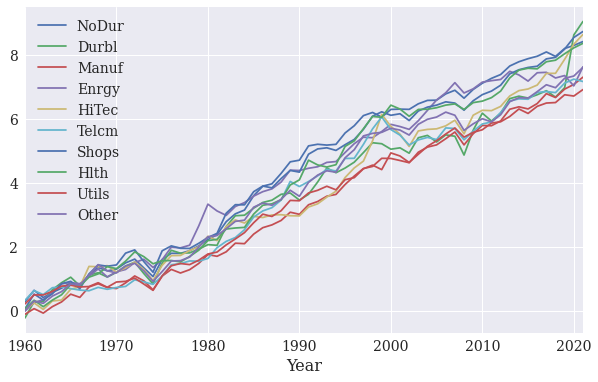

In [20]:
ind_raw.cumsum().plot();

Some industries present a high correlation (i.e. Manufacturing and others) while other present a small correlation (Energy and Durables).

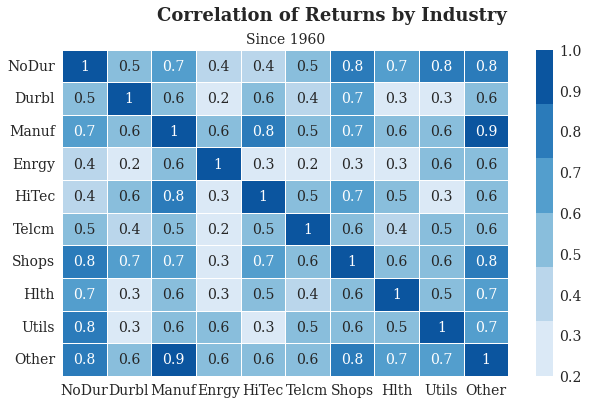

In [21]:
fig, ax = plt.subplots()
fig.suptitle('Correlation of Returns by Industry',fontweight="bold")
ax.set_title("Since 1960")
sns.heatmap(ind_raw.corr().round(1),
            cmap=sns.color_palette('Blues'), annot=True, linewidths=.5, ax=ax);

## Calculate returns by category

In [22]:
data = pd.concat((regimes, ind_raw), axis=1)
data.head()

,regimes,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Year,,,,,,,,,,,
1960,Reflation,0.2771,-0.2304,-0.1155,-0.0188,0.0180,0.3209,0.0561,0.0570,0.2091,0.0031
1961,Recovery,0.3572,0.5079,0.1763,0.2644,0.2217,0.3033,0.4600,0.2669,0.2807,0.2953
1962,Recovery,-0.2264,0.0105,-0.1385,0.0956,-0.2033,-0.1247,-0.1847,-0.2018,-0.0013,-0.0717
1963,Recovery,0.1605,0.3636,0.2019,0.2278,0.2639,0.2161,0.1923,0.2067,0.1135,0.2269
1964,Recovery,0.1302,0.2191,0.1466,0.2666,0.0301,0.0246,0.3167,0.1651,0.1618,0.1395


To continue with the regime analysis, we assign a regime every year and then calculate the median return of every industry in the different economic scenarios.

In [23]:
regs = economic_data['regimes'].unique()

In [24]:
by_reg = pd.DataFrame()
for i in regs:
    by_reg[i] = data.loc[data['regimes'] == i].drop(['regimes'], axis=1).median()

Looking at the results in a heatmap we noticed that historically, the better performing industry/regime combination is High Tech during a recovery. On the other hand, the combination with lower return is High Tech during Stagflation.

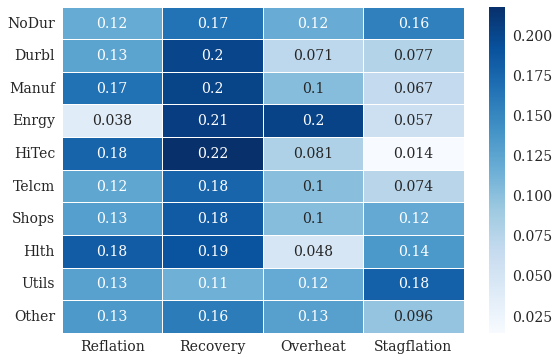

In [25]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(by_reg, annot=True, linewidths=.5, ax=ax, cmap="Blues");

In [26]:
by_reg.describe()

,Reflation,Recovery,Overheat,Stagflation
count,10.000000,10.000000,10.000000,10.000000
mean,0.132130,0.181350,0.107110,0.097515
std,0.040769,0.030155,0.041429,0.049880
min,0.037600,0.113750,0.047600,0.014250
25%,0.123750,0.168137,0.085825,0.068375
50%,0.128250,0.186950,0.101700,0.086675
75%,0.158100,0.201750,0.118875,0.131312
max,0.183100,0.217450,0.202500,0.179300


In [27]:
by_reg['color'] = ["#EF6F6C", "#465775", "#56E39F", "#08BDBD", "#5B6C5D", "#9EB7E5","#64E9EE", "#F8E16C", "#FFC2B4","#FB8F67"]

In [28]:
def plot_rets(ind):
    plot = pd.DataFrame(by_reg[[ind,'color']].sort_values(by=ind, ascending=False)).T
    fig, ax = plt.subplots()
    fig.suptitle('Regime: ' + str(ind),fontweight="bold")
    ax.set_title('Return by Industry')
    ax.set_xlabel('Industry')
    
    categ_color = plot.loc['color'].values
    
    sns.set_palette(categ_color)
    
    sns.barplot(data=pd.DataFrame(plot.loc[ind]).T);

We created charts for every regime visually appreciate the winning and losing industries for each economic scenario.

As an illustration, we can see that Energy is a low performer during Reflation but is the best industry at the Reflation stage.

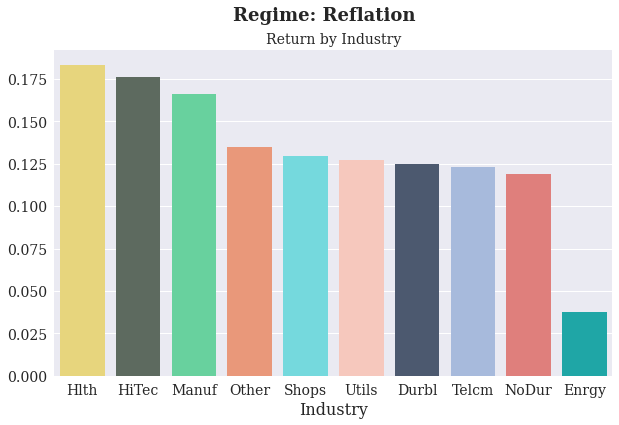

In [29]:
plot_rets('Reflation')

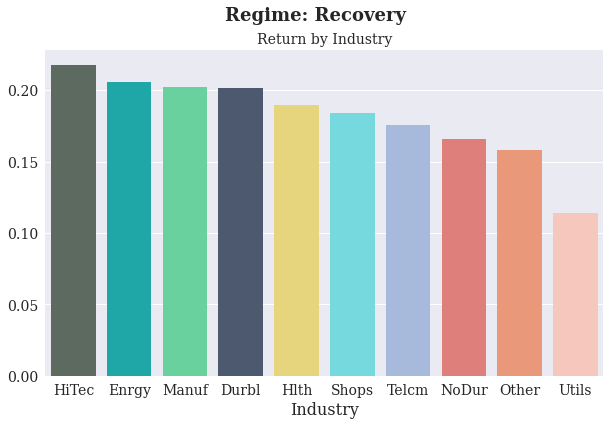

In [30]:
plot_rets('Recovery')

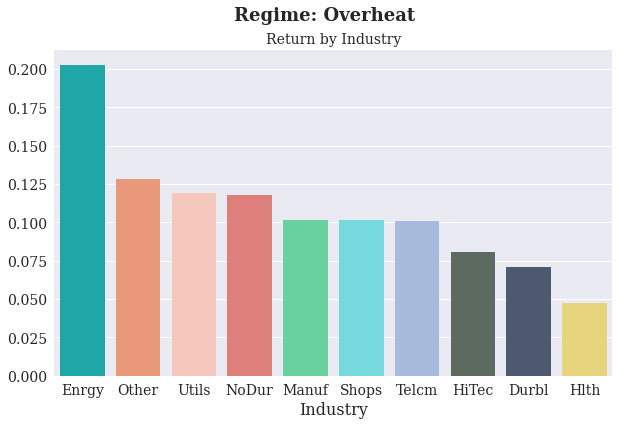

In [31]:
plot_rets('Overheat')

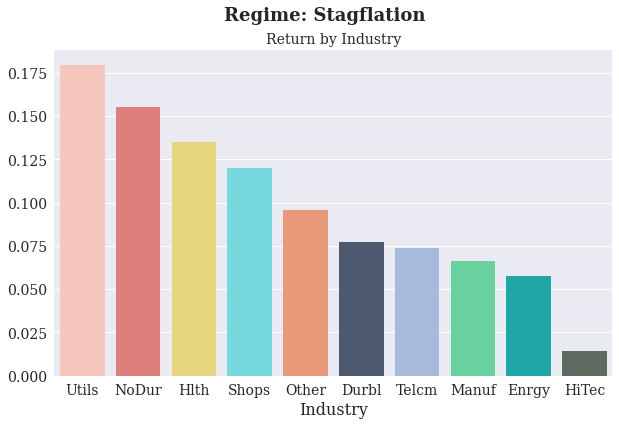

In [32]:
plot_rets('Stagflation')

## Simple Beta Calculation

As a complementary analysis, we will explain the relationship between the economic regimes and the return of the multiple industries. Given that it is not a predictive estimation, we won't use lagged variables as we will use them if we want to forecast the returns of multiple industries.

In [33]:
from sklearn.preprocessing import OneHotEncoder

In [34]:
ml_data = data.copy()

In [35]:
regimes_cat = ml_data[['regimes']]
regimes_cat.head()

,regimes
Year,
1960,Reflation
1961,Recovery
1962,Recovery
1963,Recovery
1964,Recovery


The first step is to prepare the explanatory variables (the regimes). For that, we will transform the ***regimes*** column into 4 dummy variables through a technique called One Hot Encoding.

In [36]:
cat_encoder = OneHotEncoder(sparse=False)
dummy_regimes = cat_encoder.fit_transform(regimes_cat)

In [37]:
dummy_regimes[:10]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [38]:
from sklearn.linear_model import LinearRegression

After that, we fit ten different models (one for each industry) to estimate the effect of each economic scenario in their return.

In [42]:
ml_col = cat_encoder.categories_
lr_coef= pd.DataFrame(index = ml_col)

In [43]:
for i in ind_raw.columns:
    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(dummy_regimes, ml_data[i])
    lr_coef[i] = lin_reg.coef_

As we did in the historical exercise, we plotted a heatmap to analyze the coefficients of the models that we estimated visually.

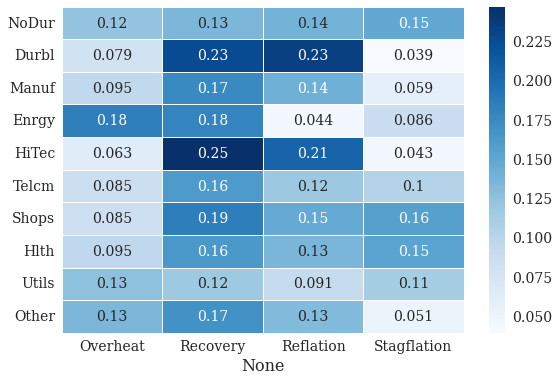

In [45]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(lr_coef.T, annot=True, linewidths=.5, ax=ax, cmap="Blues");

The results of the various linear regressions are in line with the historical results. For example, the High Tech industries perform poorly during Stagflation but overperform during recovery.

## Next steps ideas

If I had to continue with the work, there are multiple possible ways to proceed with the analysis:

1. Add extra economic indicators to define better economic scenarios
2. Transform the model into a predictive model 
    1. Explore different models in addition to linear regression (neural networks, decision trees)
    2. Backtest the models (i.e. utilizing long-short ideas absolute return or versus a benchmark)
3. Re-run the model with recent dates with a shorter periodicity like quarterly data or monthly data (PMI instead of GDP). 